## The recored simulator video on track 1
https://youtu.be/8RYJnvcv4sM 

## Two issues  
    
1) Withtout a joystick, the simulator only generates misleading datas. The steering values captured by the keyboard are mostly "-1", "1", "0", which are all wrong. So when the initial datas present from the class are not enough to cover some steep corners, I find no good way to generate trainning data except those would overfit the network ( to deal with steep corners ).    
    
2) The drive.py can only access the "center" camera image. I know it would not be a common way, but was trying to explore a network with depth=9 input ( ("center","left","right") * RGB ). I was hoping through this way can retain the info in the network that each 3 images are actually from the same frame    

*) anyway I observe the car can succesfully complete at least 6 rounds, by using some overfitting datas

### Loading data    

Peek at what's the feature datas look like. It seems the only useful data is "steering"    

{'left': ' IMG/left_2016_12_01_13_32_44_974.jpg', 'speed': '18.54293', 'right': ' IMG/right_2016_12_01_13_32_44_974.jpg', 'throttle': '0.9855326', 'brake': '0', 'center': 'IMG/center_2016_12_01_13_32_44_974.jpg', 'steering': '0'}
image count is:  9209


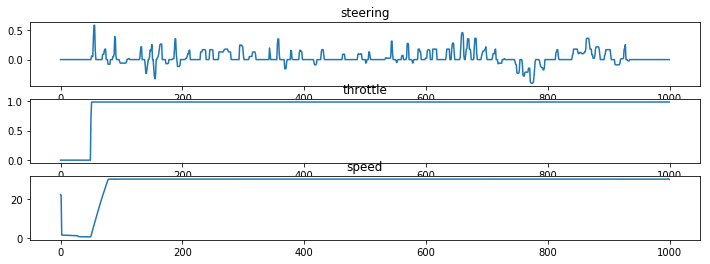

In [267]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# read in csv data
csv_data = []
with open("driving_log.csv") as f:
    f_dict = csv.DictReader(f)
    for row in f_dict:
        csv_data.append(row)

WHICH = 66
print(csv_data[WHICH])
print("image count is: ", len(csv_data))

steering_data = []
throttle_data = []
brake_data = []
speed_data = []
for row in csv_data:
    steering_data.append(row["steering"])
    throttle_data.append(row["throttle"])
    brake_data.append(row["brake"])
    speed_data.append(row["speed"])

DRAWLEN = 1000
plt.figure(figsize=(12,4))
p = plt.subplot(3,1,1)
p.plot(steering_data[0:DRAWLEN])
p.set_title("steering")
p = plt.subplot(3,1,2)
p.plot(throttle_data[0:DRAWLEN])
p.set_title("throttle")
p = plt.subplot(3,1,3)
#p.set_title(brake_data[0:DRAWLEN])
#p.set_title("brake")
#p = plt.subplot(4,1,4)
p.plot(speed_data[0:DRAWLEN])
p.set_title("speed")
plt.show()
        

### Peek the images    

Peek what the input images looks like    

image shape is:  (160, 320, 3)


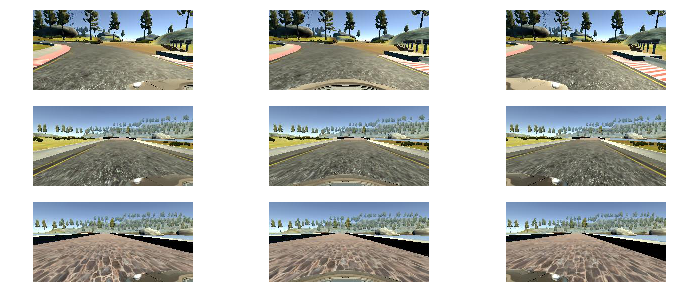

In [268]:
import numpy as np
import cv2

def process_imagefile(filename):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.0 - 0.5
    return image

WHICH = [20, 66, 99]
offset = 0
plt.figure(figsize=(12,5))
for which in WHICH:
    # center
    image_c = process_imagefile(csv_data[which]["center"].strip())
    p = plt.subplot(len(WHICH), 3, offset+2)
    p.imshow(image_c + 0.5)
    p.axis("off")
    # left
    image_l = process_imagefile(csv_data[which]["left"].strip())
    p = plt.subplot(len(WHICH), 3, offset+1)
    p.imshow(image_l + 0.5)
    p.axis("off")
    # right
    image_r = process_imagefile(csv_data[which]["right"].strip())
    p = plt.subplot(len(WHICH), 3, offset+3)
    p.imshow(image_r + 0.5)
    p.axis("off")
    
    offset += 3

print("image shape is: ", image_c.shape)

### Crop the images off trees and vehicles    

1) get rid of those trees (at top) and vehicle itself (at bottom)    
2) normalize the image data    

after the cropping, the image shape becomes (95, 320, 3)    

cropped image shape is:  (95, 320, 3)


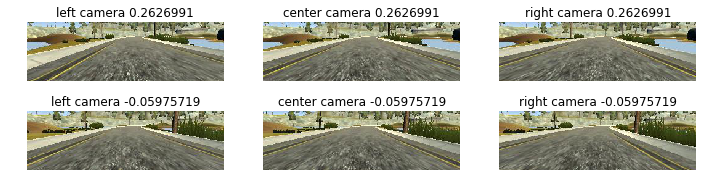

In [269]:
import numpy as np
import cv2

def process_imagefile(filename):
    filename = filename.strip()
    image = cv2.imread(filename)
    image = image[40:135,:,:]
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.0 - 0.5
    return image

WHICH = [166, 177]
offset = 0
plt.figure(figsize=(12,3))
for which in WHICH:
    ## center
    image_c = process_imagefile(csv_data[which]["center"].strip())
    steering_c = csv_data[which]["steering"]
    p = plt.subplot(len(WHICH), 3, offset+2)
    p.axis("off")
    p.set_title("center camera " + steering_c)
    p.imshow(image_c + 0.5)
    # left
    image_l = process_imagefile(csv_data[which]["left"].strip())
    steering_l = csv_data[which]["steering"]
    p = plt.subplot(len(WHICH), 3, offset+1)
    p.axis("off")
    p.set_title("left camera " + steering_l)
    p.imshow(image_l + 0.5)
    # right
    image_r = process_imagefile(csv_data[which]["right"].strip())
    steering_r = csv_data[which]["steering"]
    p = plt.subplot(len(WHICH), 3, offset+3)
    p.axis("off")
    p.set_title("right camera " + steering_r)
    p.imshow(image_r + 0.5)
    
    offset += 3

print("cropped image shape is: ", image_l.shape)
input_shape = image_l.shape

## Please forget this, sad...
### Combining images from left, center, right

This may not be a commn approach, actually I've no idea of what's the common approach of proccesing images from 3 cameras.  But I'd like to take a risk, and test my way:
Instead of taking images from 3 cameras as 3 standalone inputs, I take them as 3 depthes. Then for the CNN, the input will be 3x3(RGB) = 9 depths. 
1) the risk is the input data structure would be larger, so as the sensors of the network
2) what I hope is to retain the info " that 3 images are from the same frame", the car would take them together in every second to make the decision

Then the combined image shape becomes (95, 320, 9)

combined image shape is:  (95, 320, 9)


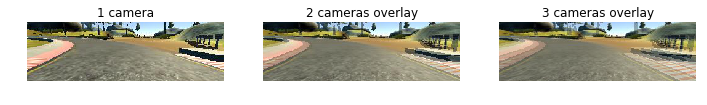

In [270]:
import random

def combine_images(csv_item):
    image = np.array(process_imagefile(csv_item["left"]))
    image = np.append(image, np.array(process_imagefile(csv_item["center"])), axis=2)
    image = np.append(image, np.array(process_imagefile(csv_item["right"])), axis=2)
    return image

# this function only gives a gut feelings of what combined images look like, no real meaning
def show_combined_images(csv_item):
    plt.figure(figsize=(12,12))
    image = np.array(process_imagefile(csv_item["left"]))
    p = plt.subplot(1, 3, 1)
    p.axis("off")
    p.set_title("1 camera")
    p.imshow(image + 0.5)
    image = image + np.array(process_imagefile(csv_item["center"]))
    p = plt.subplot(1, 3, 2)
    p.axis("off")
    p.set_title("2 cameras overlay")
    p.imshow( image/2.0 + 0.5)
    image = image + np.array(process_imagefile(csv_item["right"]))
    p = plt.subplot(1, 3, 3)
    p.axis("off")
    p.set_title("3 cameras overlay")
    plt.imshow(image/3.0 + 0.5)

WHICH = 20
image_3 = combine_images(csv_data[WHICH])
show_combined_images(csv_data[WHICH])

print("combined image shape is: ", image_3.shape)

#print(process_imagefile(csv_data[WHICH]["left"][0][0]))
#print(image[0][0])

### Split data    

90% data for trainning, 10% for validation.  Some of datas are from the class which are good and general, others are from keyboard with the simulator, and overfit the deep corners on purpose...   
    
The datas are shuffled before the spliting, as newly captured datas is beind the datas from the class
  

In [283]:
import random

# shuffle before spliting data, so newly captured datas won't all fall in validationg set
random.shuffle(csv_data)
split_index = len(csv_data) * 9 // 10
train_data = csv_data[:split_index]
valid_data = csv_data[split_index:]

print("New nuumber of training examples =", len(train_data))
print("New nuumber of validation examples =", len(valid_data))

New nuumber of training examples = 8288
New nuumber of validation examples = 921


### The generator    
1) for left camera images, add 0.25 to the steering values; for right camera images, substract 0.25;  in order to match "center" images   
   
2) for trainning data, do shuffle before generating each batch   
&emsp; *) as the keyboard input datas problem stated, give input with steering < 0.001 a 50% probability of skipping, i.e. not use  
   
3) for validation data, since this is my first time trying Python generator syntax, I made two mistakes  
&emsp; a) the validation data need to fill in one dimention in the front , so can compare with batch data, e.g. ( None, 1234, 4353, 9 ) , ( None, 0.1243)  
&emsp; b) the generated data shouldn't be limitted to len(data) , or the keras will start to complain about " generator outputs None data" from the second epoch   

In [291]:
import random

# if left camera, correct the steering by + 0.2
# if right camera, correct the steering by - 0.2
def process_steering(csv_item, direction):
    data = float(csv_item["steering"])
    #if abs(data) < 0.01:
    #    data = 0.0
    if direction == "left": 
        return data + 0.25
    elif direction == "right":
        return data - 0.25
    else: # "center"
        return data

# for validation data , cover all datas, no random picks    
def traverse_data_generator(csv_data):
    # after 1 epoch, we will need data more than len(csv_data)
    while True:
        for csv_item in csv_data:
            for direction in ["left", "center", "right"]:
                x = process_imagefile(csv_item[direction])
                # push 1 dimention in the front to match training batch shape
                x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
                y = process_steering(csv_item, direction)
                # also push 1 dimention in the front
                y = np.array([[y]])
                yield x,y

# do shuffle before each batch 
# if the post-processing steering == 0, give a 90% change of not using it 
# ( without a joystick, the simulator can only generate misleading data)
def batch_data_generator(csv_data, batch_size=128):
    while True:
        random.shuffle(csv_data)
        batch_x = []
        batch_y = []
        cnt = 0
        while True:      
            i = random.randrange(len(csv_data))
            if abs(process_steering(csv_data[i], "center")) < 0.001:
                if random.random() < 0.5 : 
                    continue 
            direction = ["left", "center", "right"][random.randrange(3)]                 
            batch_x.append(process_imagefile(csv_data[i][direction]))
            batch_y.append(process_steering(csv_data[i], direction))
            cnt += 1
            if cnt == batch_size:
                break
        yield np.array(batch_x), np.array(batch_y)

valid_gen = traverse_data_generator(valid_data)
train_gen = batch_data_generator(train_data)

x,y = next(valid_gen)
print("validation image shape", x.shape)
print("validation steering shape: ", y.shape)
x,y = next(train_gen)
print("shuffled image shape", x.shape)
print("shuffled steering shape: ", y.shape)
print("shuffled steering batch:\n", y)


validation image shape (1, 95, 320, 3)
validation steering shape:  (1, 1)
shuffled image shape (128, 95, 320, 3)
shuffled steering shape:  (128,)
shuffled steering batch:
 [  7.50000000e-01   1.26991000e-02   0.00000000e+00  -2.50000000e-01
   3.11759900e-01  -2.50000000e-01  -2.90768470e-01  -2.50000000e-01
   0.00000000e+00  -4.61666900e-01   1.00000000e+00   1.00034000e-01
   1.25000000e+00  -2.50000000e-01   2.50000000e-01   5.21913700e-02
   4.26582300e-01  -2.50000000e-01   2.28220240e-01  -6.13834300e-01
  -7.87459000e-02  -9.25548000e-02   1.04793600e-01  -1.02123300e-01
   4.07445200e-01   0.00000000e+00  -1.97808630e-01   1.71254100e-01
   1.71254100e-01  -7.50000000e-01   2.63917240e-01   2.22676000e-02
  -2.50000000e-01   2.22676000e-02  -1.59534500e-01  -7.34177000e-02
  -3.28745900e-01   2.50000000e-01   9.52992000e-02   1.67013800e-01
  -8.82402600e-02   4.17013800e-01  -2.50000000e-01   3.78739600e-01
   1.90242810e-01  -2.50000000e-01  -1.49966000e-01  -2.78127400e-01


### Build the keras model

One thing I find out is too much use of dropout and maxpooling would erase all useful info, and generate meaningless output. So for each convolution layer, I choose only one of them.   
&emsp; 1) favoring dropout will increase the network sensors, and heavy the computation workload    
&emsp; 2) favoring maxpooling would give worse output than dropout    
    
layer1 is a conv2d with 5x5 kernel and 24 depths. Input as [batch_size, image_shape]. Followed by an "elu" activation and maxpooling with kernel 2x2    
layer2 is a conv2d with 5x5 kernel and 36 depths. Followed by an "elu" activation and maxpooling with kernel 2x2    
layer3 is a conv2d with 5x5 kernel and 48 depths. Followed by an "elu" activation and maxpooling with kernel 2x2    
layer4 is a conv2d with 3x3 kernel and 64 depths. Followed by an "elu" activation and dropout = 0.5    
layer5 is a conv2d with 3x3 kernel and 64 depths. Followed by an "elu" activation and dropout = 0.5   
layer6 is a full connection layer with 100 sensors. Followed by an "elu"  
layer7 is a hidden layer with 50 sensors. Followed by an "elu"   
layer8 is a hidden layer with 10 sensors. layer with 100 sensors. Followed by an "elu"    
layer9 is a output layer 1 output. Followed by an "elu"    
  
The optimization method is the default "adam", the error function is "mse" which looks like not that useful. So I spared a very small amount of validation data set   

In [289]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation, Dropout, Dense
from keras.optimizers import SGD, Adam, RMSprop

def get_model(shape):
    model = Sequential()
    
    model.add(Conv2D(24, 5, 5, input_shape=shape, activation='elu', name="conv1"))
    model.add(MaxPooling2D((2,2)))
    #model.add((Dropout(0.5)))
    
    model.add(Conv2D(36, 5, 5, activation='elu', name="conv2"))
    model.add(MaxPooling2D((2,2)))
    #model.add((Dropout(0.5)))
    
    model.add(Conv2D(48, 5, 5, activation='elu', name="conv3"))
    model.add(MaxPooling2D((2,2)))
    #model.add((Dropout(0.5)))
    
    model.add(Conv2D(64, 3, 3, activation='elu', name="conv4"))
    #model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5))) 
    
    model.add(Conv2D(64, 3, 3, activation='elu', name="conv5"))
    #model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5))) 
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu', name="hidden1"))
    model.add(Dense(50, activation='elu', name="hidden2"))
    model.add(Dense(10, activation='elu', name="hidden3"))
    model.add(Dense(1, activation='elu', name="output"))

    # learning rate
    #adam = Adam(lr=0.001)
    
    model.compile(optimizer='adam', loss='mse')
    return model

model = get_model(input_shape)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution2D)            (None, 91, 316, 24)   1824        convolution2d_input_33[0][0]     
____________________________________________________________________________________________________
maxpooling2d_97 (MaxPooling2D)   (None, 45, 158, 24)   0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 41, 154, 36)   21636       maxpooling2d_97[0][0]            
____________________________________________________________________________________________________
maxpooling2d_98 (MaxPooling2D)   (None, 20, 77, 36)    0           conv2[0][0]                      
___________________________________________________________________________________________

### Start the training  
   
The batch_size is 128 as 256 will overflow GPU.   
The EPOCH is 5. From the validation lose value, a larger EPOCH could continue to give better results.   

In [274]:
import os
import json
from pathlib import Path

def save_model(file_model, file_weights):
    if Path(file_model).is_file():
        os.remove(file_model)
    json_data = model.to_json()
    with open(file_model,'w' ) as f:
        json.dump(json_data, f)
    if Path(file_weights).is_file():
        os.remove(file_weights)
    model.save_weights(file_weights)
    print("\nmodel saved in files: ", file_model, file_weights)

In [290]:
BATCH_SIZE = 128
valid_gen = traverse_data_generator(valid_data)
train_gen = batch_data_generator(train_data, BATCH_SIZE)
samples_per_epoch = len(train_data) // BATCH_SIZE * BATCH_SIZE  # must be mutiple of batch size, 
                                                                # len(train_data) is an approximate value 
                                                                # as already dropped 90% of steering == 0 data  
nb_val_samples = len(valid_data)*3

EPOCH = 5
    
history = model.fit_generator(generator=train_gen,
                              samples_per_epoch=samples_per_epoch,
                              nb_epoch=EPOCH, 
                              validation_data=valid_gen,
                              nb_val_samples=nb_val_samples)

save_model("model.json", "model.h5")


Epoch 1/5
8192/8192 [==============================] - 61s - loss: 0.1419 - val_loss: 0.0497

## Reflection  
  
1) With no joystick, I can't get enough good datas. Some tricks and on purpose overfitting are used with no choice, the trained model can't be general.   
   
2) From last project, I learned "garbage in , garbage out", which is verificed again in this project. From my personal view, the good pre-processing techniches are even more useful than playing with training network architecture    
   
3) Accessing to a GPU is a must to caliberate a network.  
   